# Test for bike trafic model

## INIT

In [47]:
import sys
from pathlib import Path

CURRENT_DIR = Path().resolve().parents[0]
DATA_DIR = CURRENT_DIR / "data"
SRC_PATH = CURRENT_DIR / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.cm as cm
from matplotlib.lines import Line2D
from shapely.geometry import LineString, Polygon

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix
import warnings

warnings.filterwarnings('ignore')

from utils_sta import ta_due, ta_stochastic, plot_vc_histogram
import logging
logging.getLogger("aequilibrae").setLevel(logging.ERROR)

In [ ]:
### TODO: séparer les fonction dans des scripts
#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line. From utils_traffic.py by Bahman"""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None):
    
    """ Plot a network with edge widths and colors based on specified columns. Adapted from utils_traffic.py by Bahman """

    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    if color_col_num is None and color_col_str is None:
        color_vals = ['black'] * len(edges_df)
        use_cmap = False
        
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f'Network (width by {width_col})')
    plt.tight_layout()
    
    if ax is None:
        return fig, ax

def plot_od_matrix(od_matrix, edges_df, nodes_df, ax=None, figsize=(10,10), cmap='viridis', title='OD Matrix', label=True, color='red', vmax=None):
    """ Plot OD matrix as arrows on the network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    plot_network(edges_df, nodes_df, ax=ax, show_nodes=True, node_label=True, node_size=300, title=title)
    od_matrix_plot = od_matrix.copy()[od_matrix['demand']>0]
    if vmax is None:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / od_matrix_plot['demand'].max() * 5
    else:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / vmax * 5
    

    for i, row in od_matrix_plot.iterrows():
        x0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'x'].values[0]
        y0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'y'].values[0]
        x1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'x'].values[0]
        y1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'y'].values[0]

        ax.annotate(
        "",
        xy=(x1, y1),      # destination
        xytext=(x0, y0),  # origine
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            lw=row['linewidth']
        ),
        zorder=3
        )
        if label :
            xm = (x0 + x1-100) / 2
            ym = (y0 + y1+100) / 2
            dx = x1 - x0
            dy = y1 - y0

            # Vecteur perpendiculaire unitaire
            nx = -dy
            ny = dx
            norm = np.sqrt(nx**2 + ny**2)
            nx /= norm
            ny /= norm

            # Distance du décalage (à ajuster si besoin)
            offset = 0.015 * np.hypot(dx, dy)

            # Position finale du texte
            xt = xm + nx * offset
            yt = ym + ny * offset

            # Texte
            ax.text(
                xt, yt,
                str(int(row['demand'])),
                color='black',
                fontsize=9,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=4
            )

    if ax is None:
        return fig, ax
    

#### Network preprocessing functions

def calculate_length(node_df, edge_df):
    """ Calculate Euclidean length of edges based on node coordinates. """
    lengths = []
    for edge in edge_df.itertuples():
        a_node = node_df.loc[node_df['node'] == edge.a_node]
        b_node = node_df.loc[node_df['node'] == edge.b_node]
        length = np.sqrt((a_node['x'].values[0] - b_node['x'].values[0])**2 + (a_node['y'].values[0] - b_node['y'].values[0])**2)
        lengths.append(length)
    return edge_df.assign(length=lengths)

def calculate_congested_time(edges_df, free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4):
    """Calculate congested travel time using BPR function.
    𝑇=𝑇0(1+α(𝑉/𝐶)^β)
    where:
    - 𝑇 is the congested travel time
    - 𝑇0 is the free-flow travel time
    - 𝑉 is the volume (flow)
    - 𝐶 is the capacity
    - α and β are parameters
    """
    edges_df[congested_time_name]=edges_df[free_flow_time_name]*(1+alpha*(edges_df[flow_name]/edges_df[capacity_name])**beta)
    return edges_df
    
### eaquilibrea interface processing

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

## Test of TA function

### Importation and preprocessing of the network

In [49]:
edge_df = pd.read_csv(DATA_DIR / "edges_small_grid_2.csv")
node_df = pd.read_csv(DATA_DIR / "nodes_small_grid_2.csv")

edge_df = calculate_length(node_df, edge_df)
edge_df["length"] *= 10 
edge_df["type_bike"] = None
edge_df["speed_bike"] /= 3.6
edge_df["speed_car"] /= 3.6
edge_df["travel_time_bike"] = edge_df["length"] / edge_df["speed_bike"]
edge_df["free_flow_time"] = edge_df["length"] / edge_df["speed_car"]
edge_df["travel_time_car"] = edge_df["free_flow_time"]
edge_df["capacity_cars"] = 3000
edge_df["capacity_bikes"] = 99999
edge_df["alpha"] = 0.15
edge_df["beta"] = 4

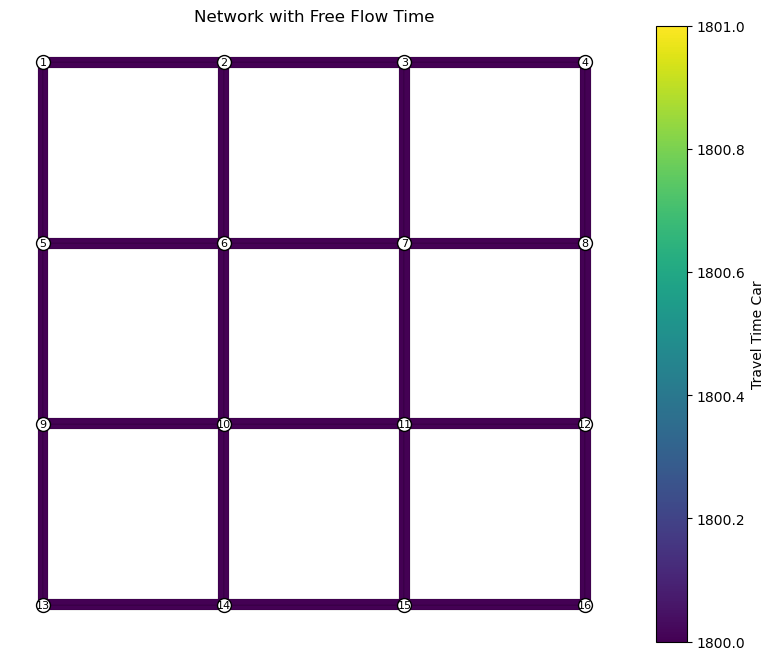

In [50]:
plot_network(edge_df, node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='travel_time_car',
            base_width=1,
            legend=True,
            title="Network with Free Flow Time",
            figsize=(8,8))

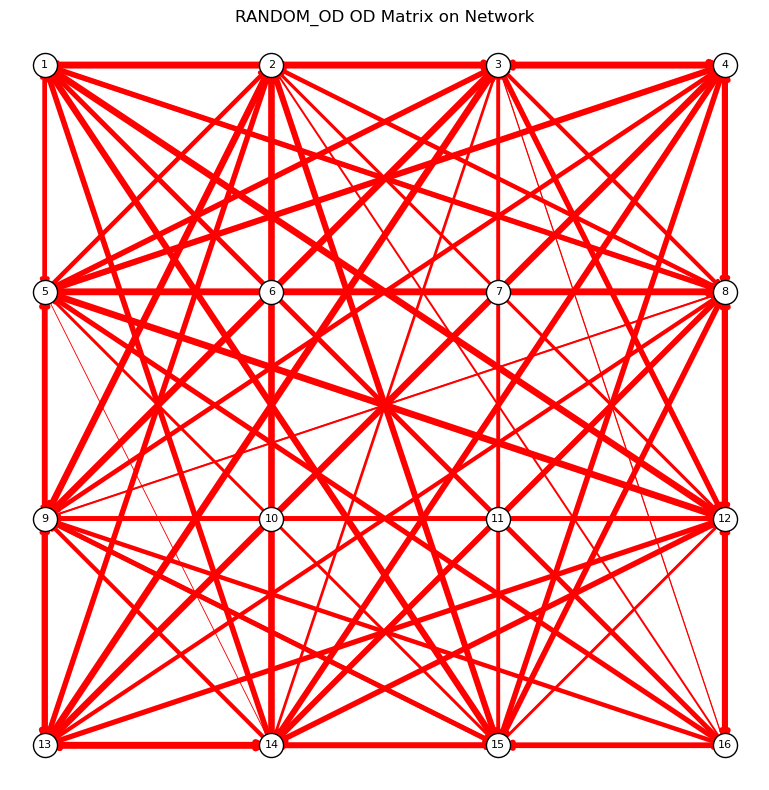

In [51]:
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,max(node_df['node'])+1), columns=range(1,max(node_df['node'])+1))

OD_SCENARIO = "RANDOM_OD" # Options: "1OD", "2OD", "RANDOM_OD"

if OD_SCENARIO == "1OD":
    od_matrix.loc[1,16] = 1000
elif OD_SCENARIO == "2OD":
    od_matrix.loc[1,16] = 1000
    od_matrix.loc[13,4] = 1000
elif OD_SCENARIO == "RANDOM_OD":
    liste_i = [1,2,3,4,5,8,9,12,13,15,14,16]
    for i in liste_i:
        for j in liste_i:
            if i != j:
                od_matrix.loc[i,j] = np.random.randint(20,1000)
size_od = od_matrix.index.max()

od_matrix_eaq = convert_to_eaquilibrae_od_matrix(od_matrix)
plot_od_matrix(od_matrix_eaq, edge_df, node_df, title=f"{OD_SCENARIO} OD Matrix on Network", figsize=(8,8), label=False)

### Test of ta_due

DUE completed in 0.35s | RGAP: 0.000097 | TTT: 638626171


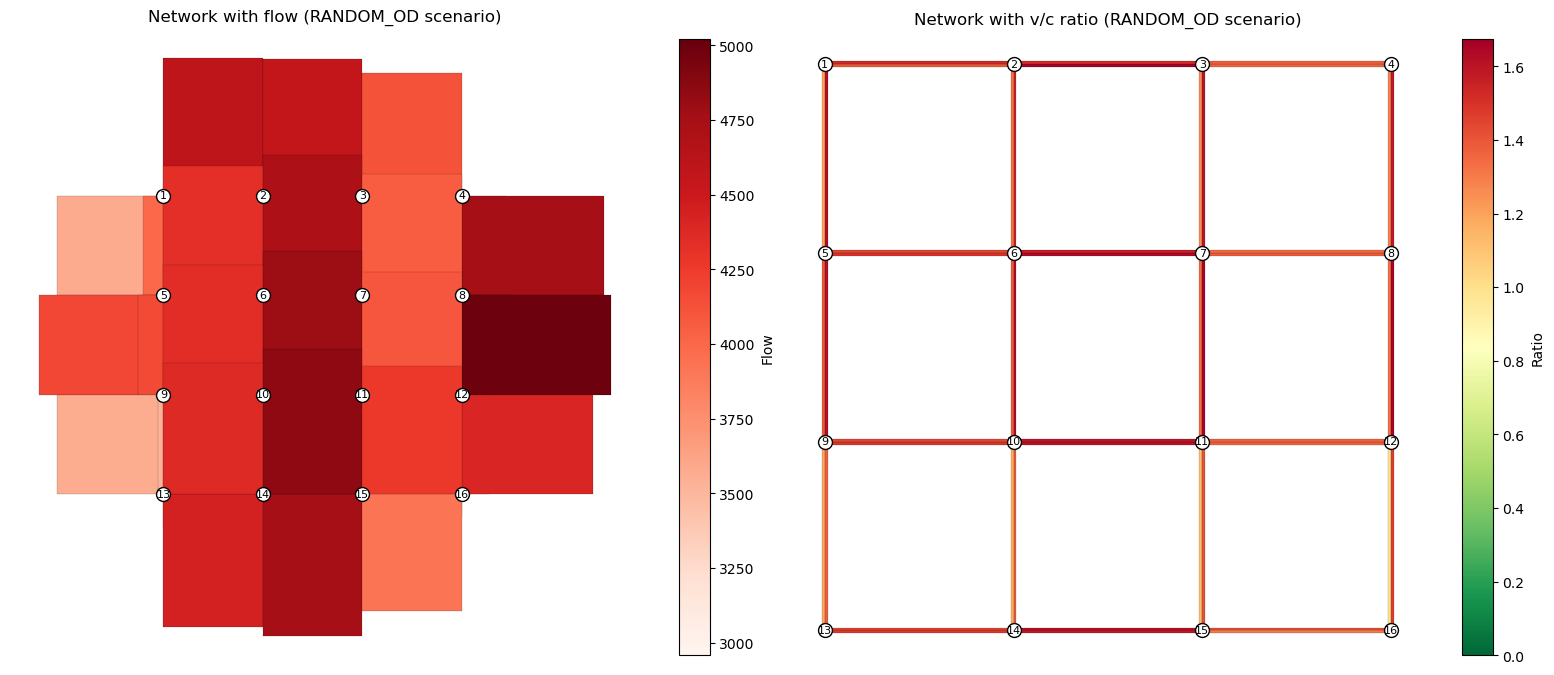

In [52]:
results_due = ta_due(edge_df, od_matrix_eaq, algorithm='bfw', max_iter=500, tolerance=1e-4,
           time_field='travel_time_car', cost_field='travel_time_car', capacity_field='capacity_cars', verbose=True)
fig, axes = plt.subplots(1,2, figsize=(16,8))
plot_network(results_due['network'], node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='flow',
            base_width=0.1,
            width_col='flow',
            width_scale=100,
            legend=True,
            title=f"Network with flow ({OD_SCENARIO} scenario)",
            figsize=(8,8),
            cmap='Reds',
            vmax=results_due['network']['flow'].max(),
            vmin=results_due['network']['flow'].min(),
            ax=axes[0])
plot_network(results_due['network'], node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='ratio',
            base_width=0.5,
            width_col='ratio',
            width_scale=100,
            legend=True,
            title=f"Network with v/c ratio ({OD_SCENARIO} scenario)",
            figsize=(8,8),
            cmap='RdYlGn_r',
            vmax=results_due['network']['ratio'].max(),
            vmin=0,
            ax=axes[1])

### Test of ta_stochastic

Stochastic (bike) completed in 0.01s | TTT: 438513882


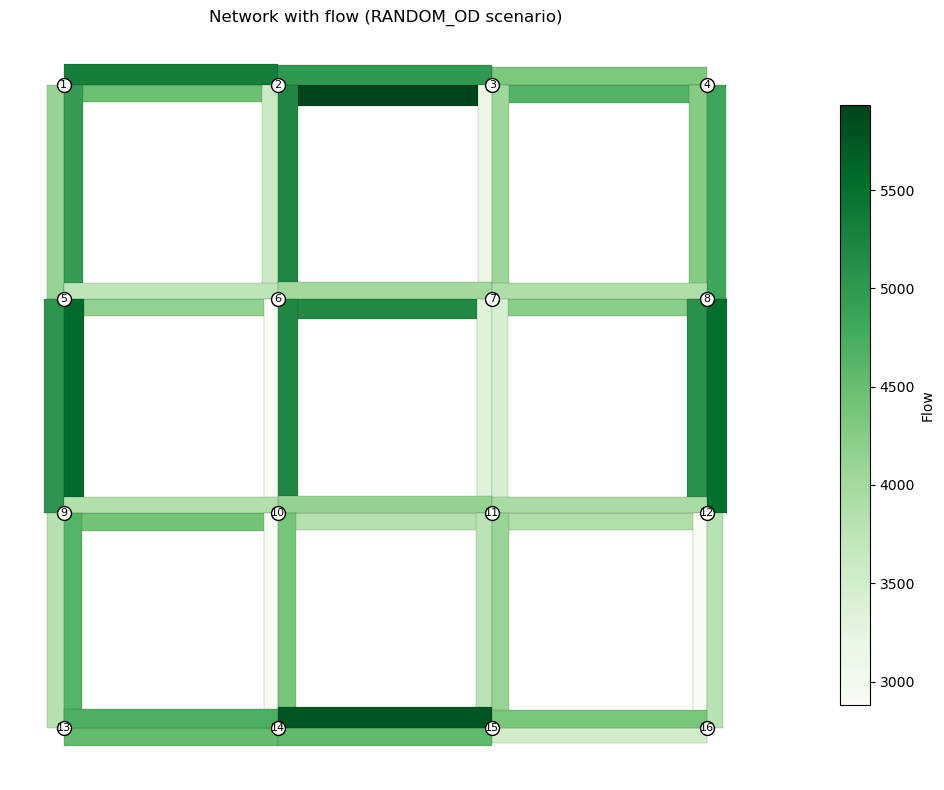

In [53]:
results_sto = ta_stochastic(edge_df, od_matrix_eaq, mode='bike',
                  time_field='travel_time_bike', cost_field='travel_time_bike', capacity_field='capacity_bikes',
                  algorithm='bfsle', max_routes=3, max_depth=100, verbose=True)
fig, ax = plt.subplots(figsize=(16,8))
plot_network(results_sto['network'], node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='flow',
            base_width=1,
            width_col='flow',
            width_scale=4,
            legend=True,
            title=f"Network with flow ({OD_SCENARIO} scenario)",
            figsize=(8,8),
            cmap='Greens',
            vmax=results_sto['network']['flow'].max(),
            vmin=results_sto['network']['flow'].min(),
            ax=ax)
plt.show()

## Test of mode choice


--- Mode Choice Loop 1 ---
Mode shares with skimming: Car = 99.930 %, Bike = 0.070%


DUE completed in 0.49s | RGAP: 0.000068 | TTT: 638225815
Stochastic (bikes) completed in 0.00s | TTT: 104650


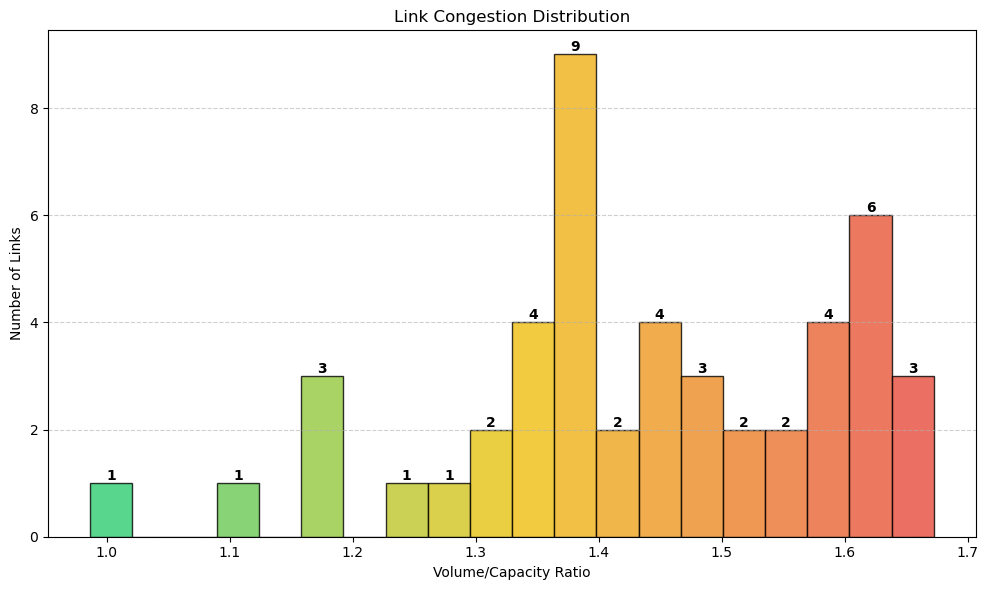

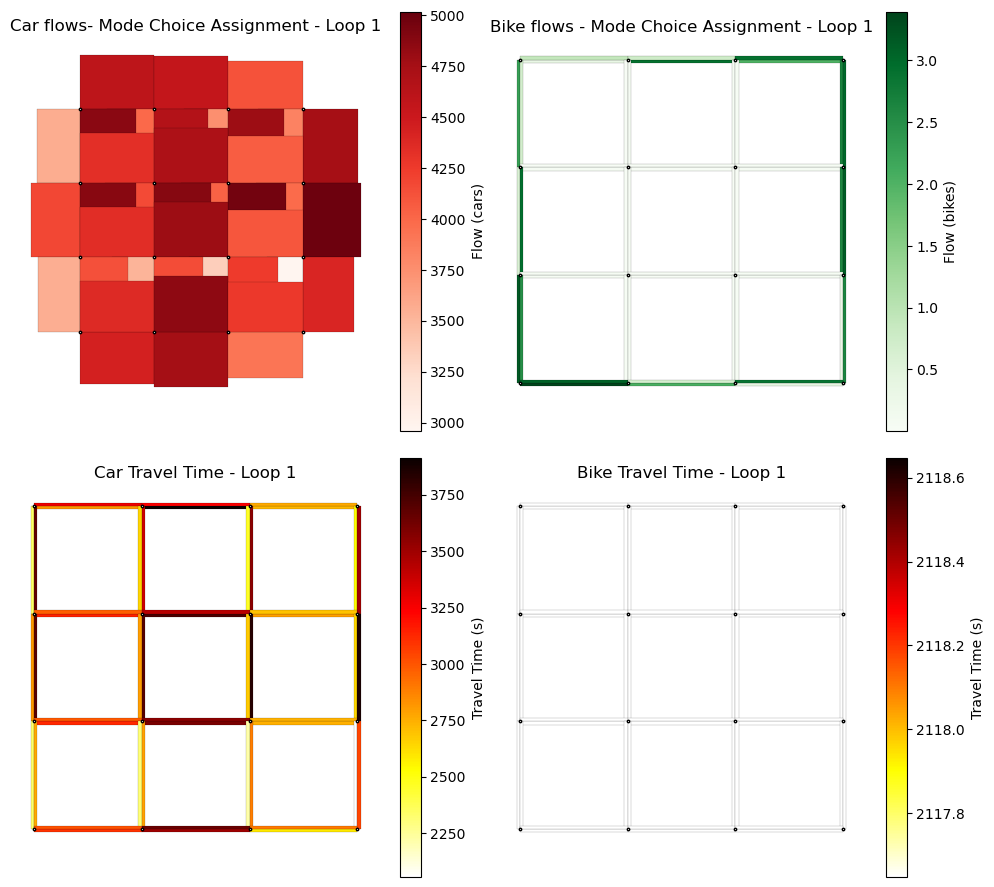


--- Mode Choice Loop 2 ---
Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


DUE completed in 1.11s | RGAP: 0.000000 | TTT: 2938718
Stochastic (bikes) completed in 0.00s | TTT: 435894493


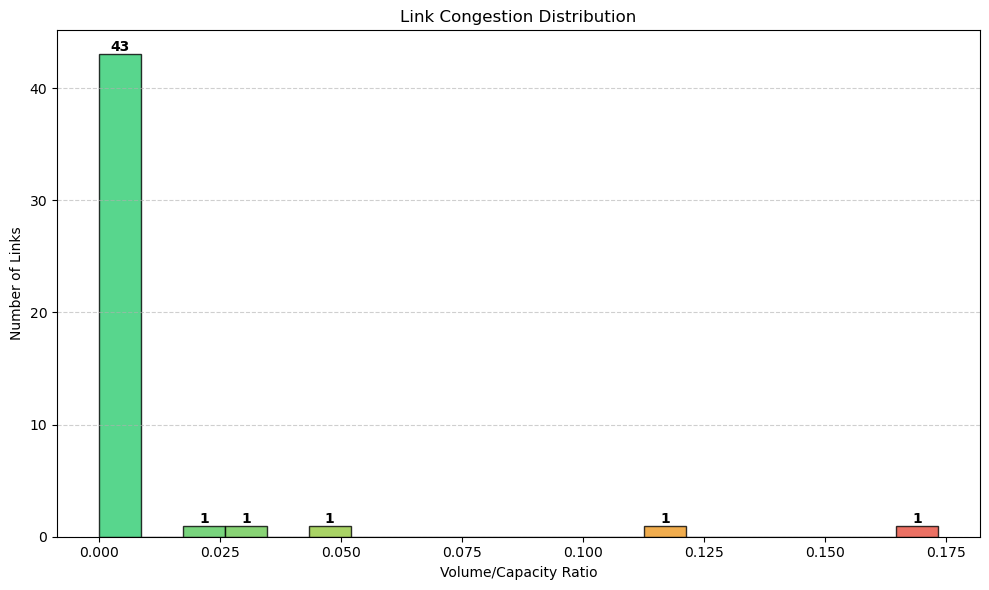

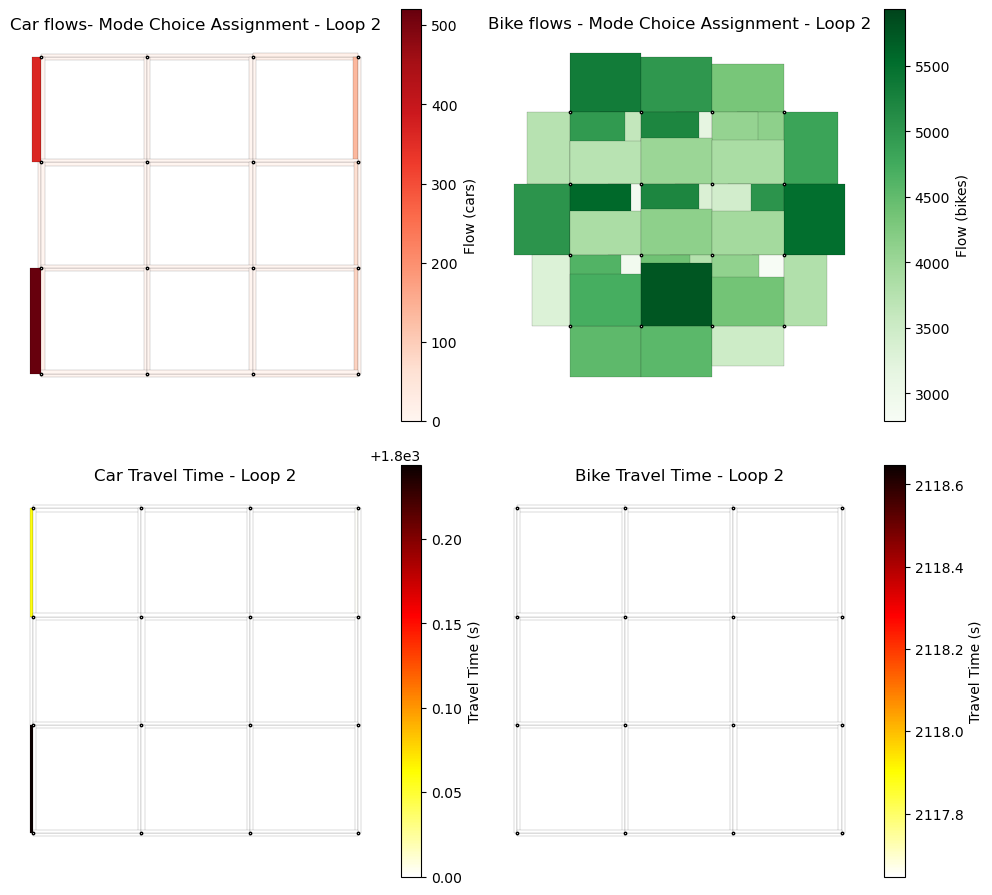


--- Mode Choice Loop 3 ---
Mode shares with skimming: Car = 99.930 %, Bike = 0.070%


DUE completed in 0.50s | RGAP: 0.000068 | TTT: 638225815
Stochastic (bikes) completed in 0.01s | TTT: 104650


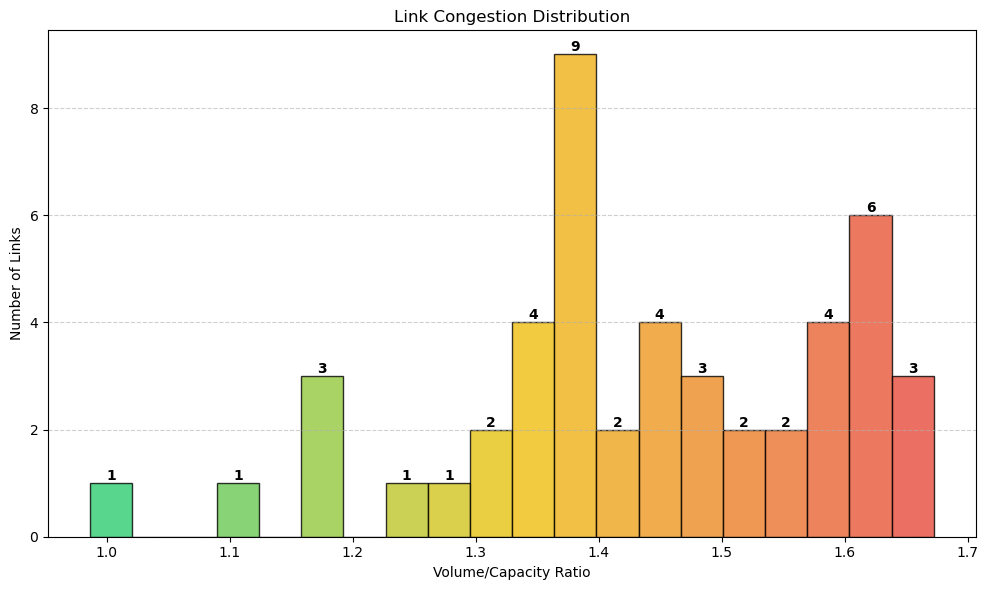

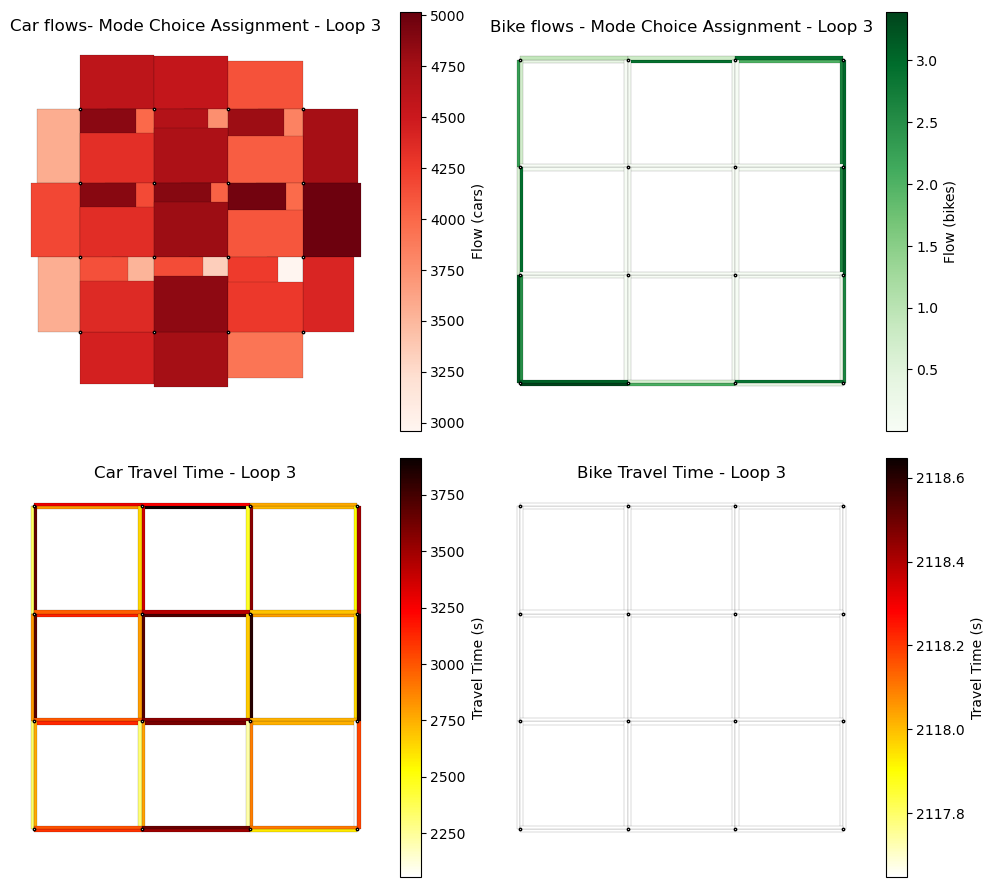


--- Mode Choice Loop 4 ---
Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


DUE completed in 0.31s | RGAP: 0.000000 | TTT: 2938718
Stochastic (bikes) completed in 0.00s | TTT: 435894493


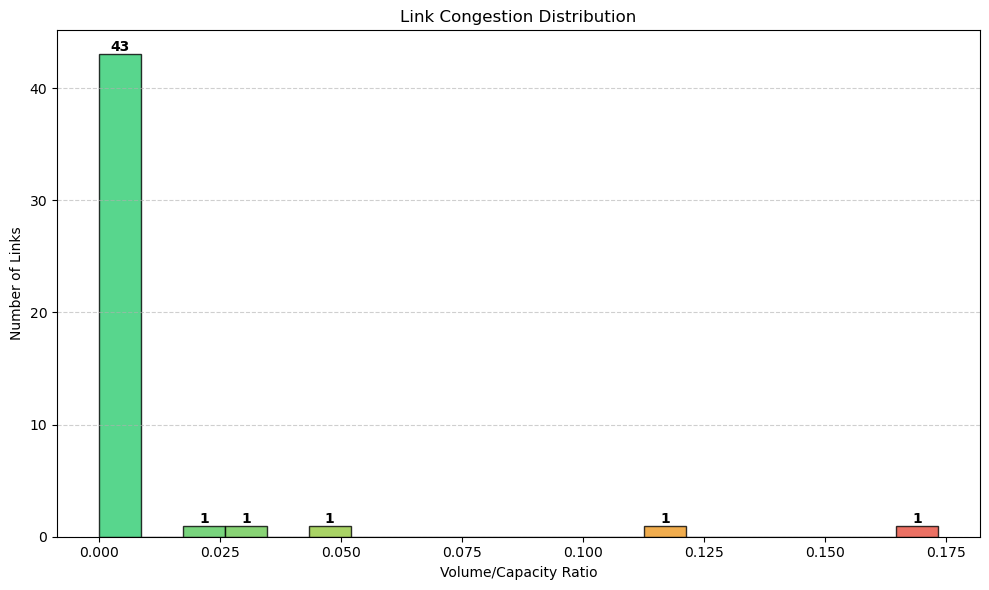

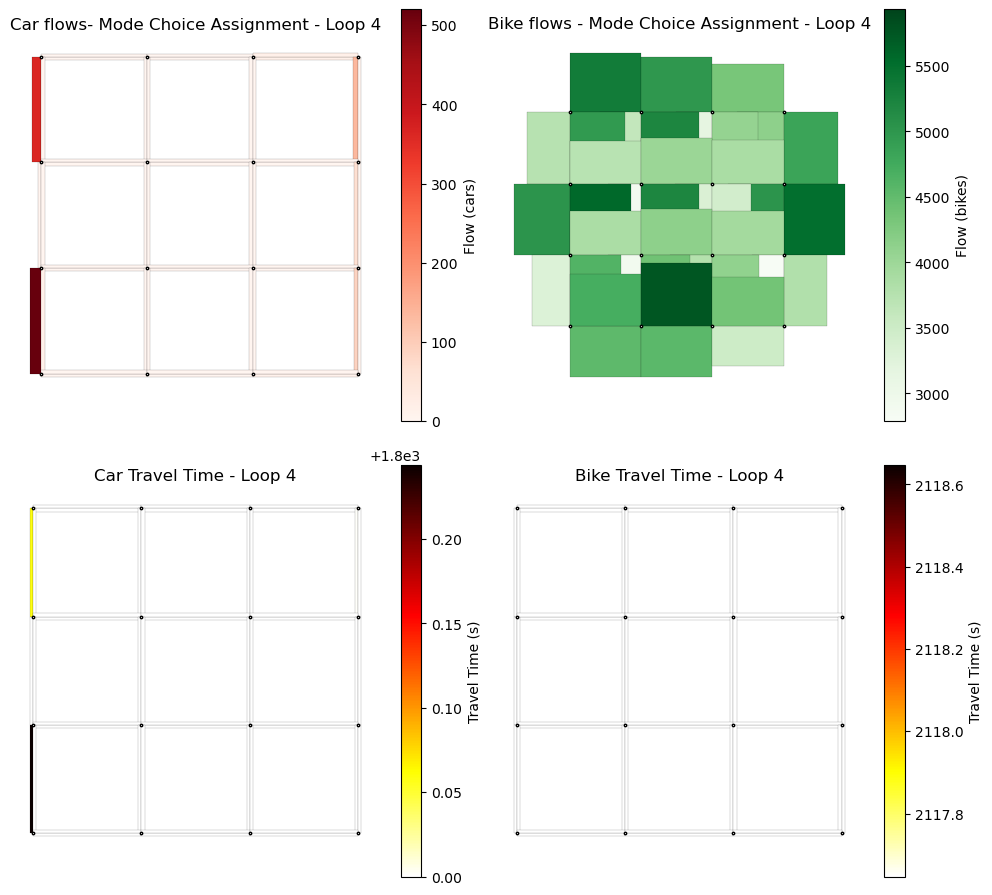


--- Mode Choice Loop 5 ---
Mode shares with skimming: Car = 99.930 %, Bike = 0.070%


DUE completed in 0.53s | RGAP: 0.000068 | TTT: 638225815
Stochastic (bikes) completed in 0.00s | TTT: 104650


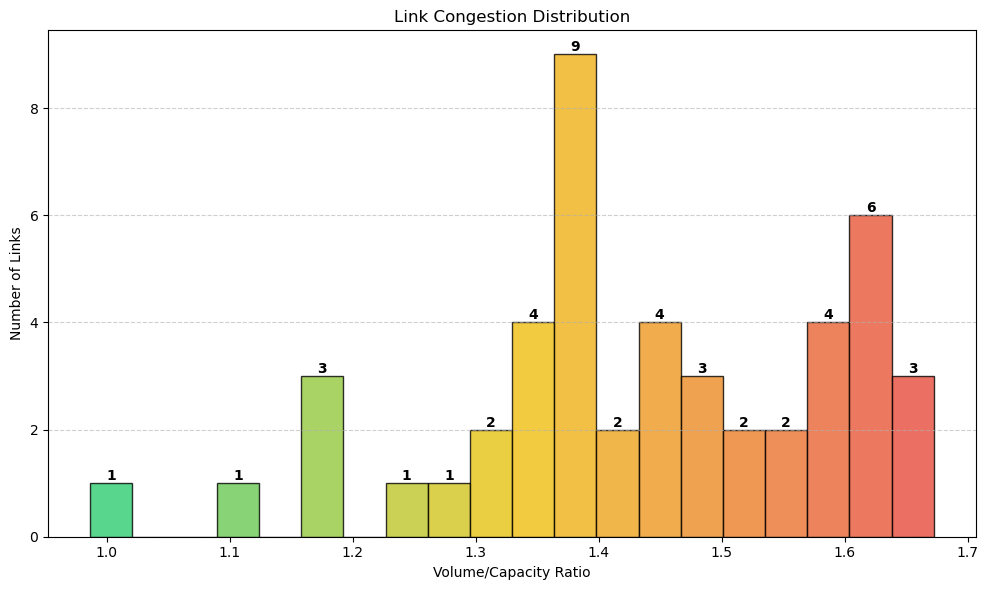

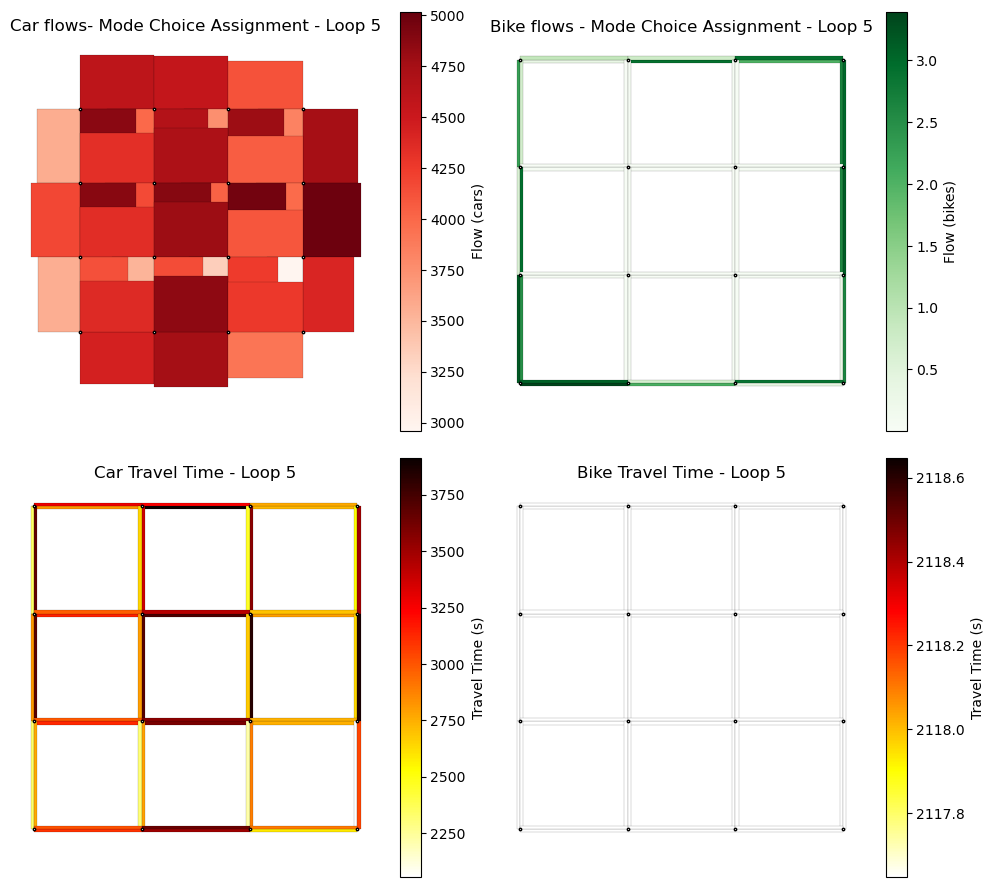


--- Mode Choice Loop 6 ---
Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


DUE completed in 1.56s | RGAP: 0.000000 | TTT: 2938718
Stochastic (bikes) completed in 0.00s | TTT: 435894493


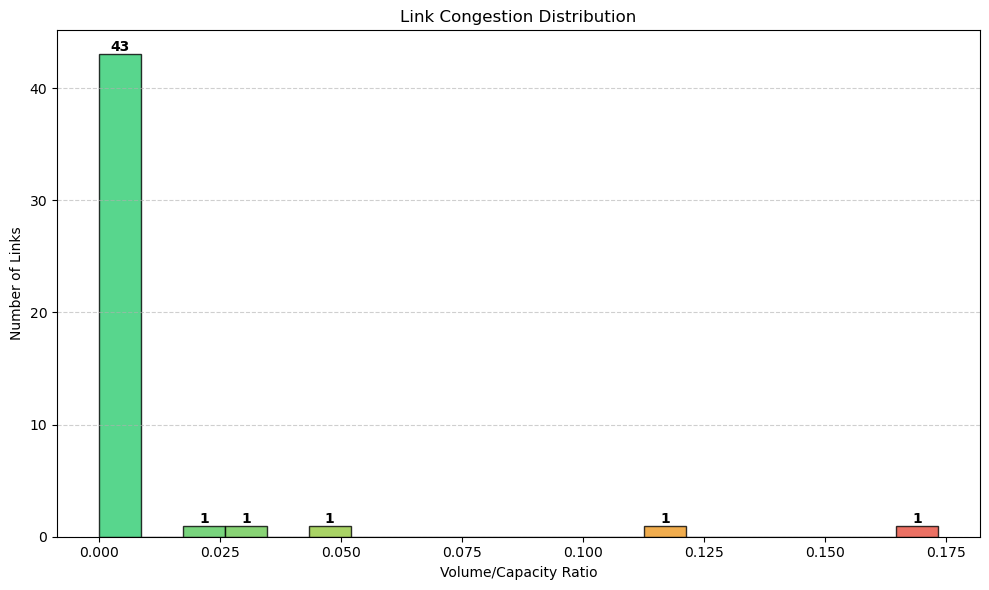

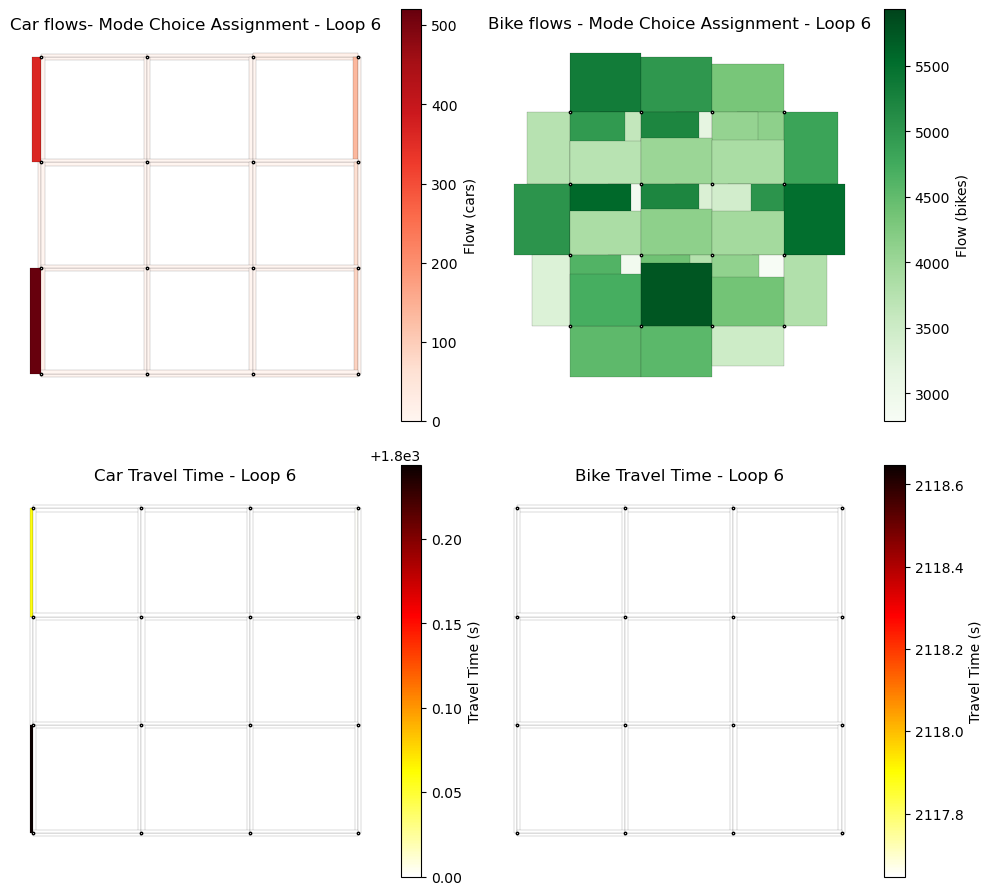


--- Mode Choice Loop 7 ---
Mode shares with skimming: Car = 99.930 %, Bike = 0.070%


DUE completed in 0.52s | RGAP: 0.000068 | TTT: 638225815
Stochastic (bikes) completed in 0.01s | TTT: 104650


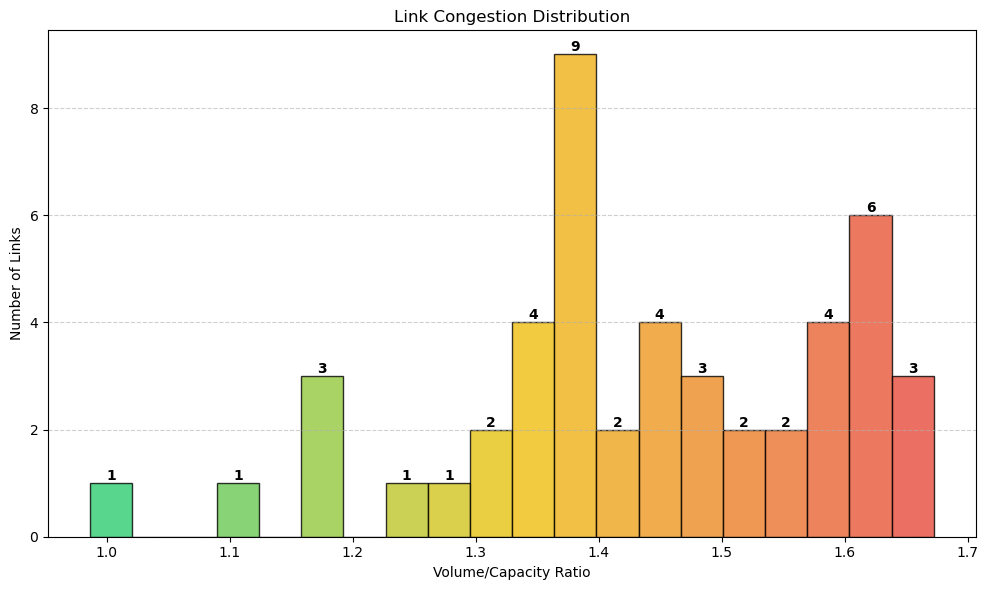

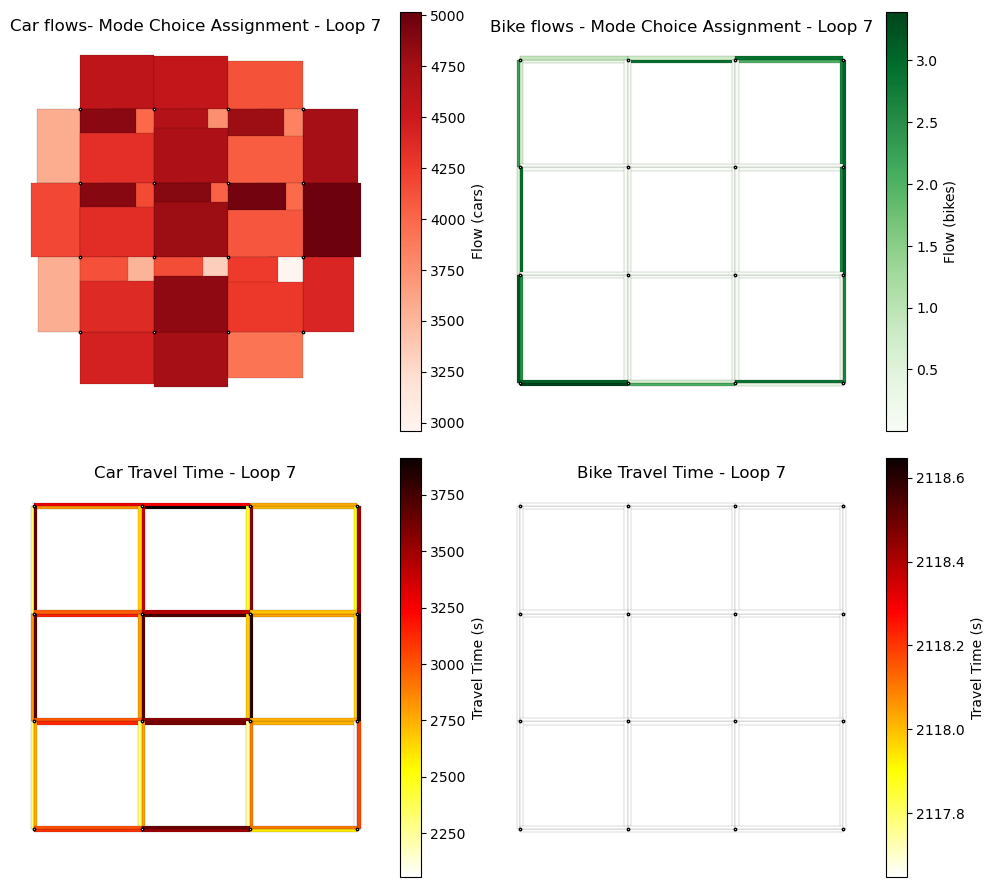


--- Mode Choice Loop 8 ---
Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


DUE completed in 0.24s | RGAP: 0.000000 | TTT: 2938718
Stochastic (bikes) completed in 0.00s | TTT: 435894493


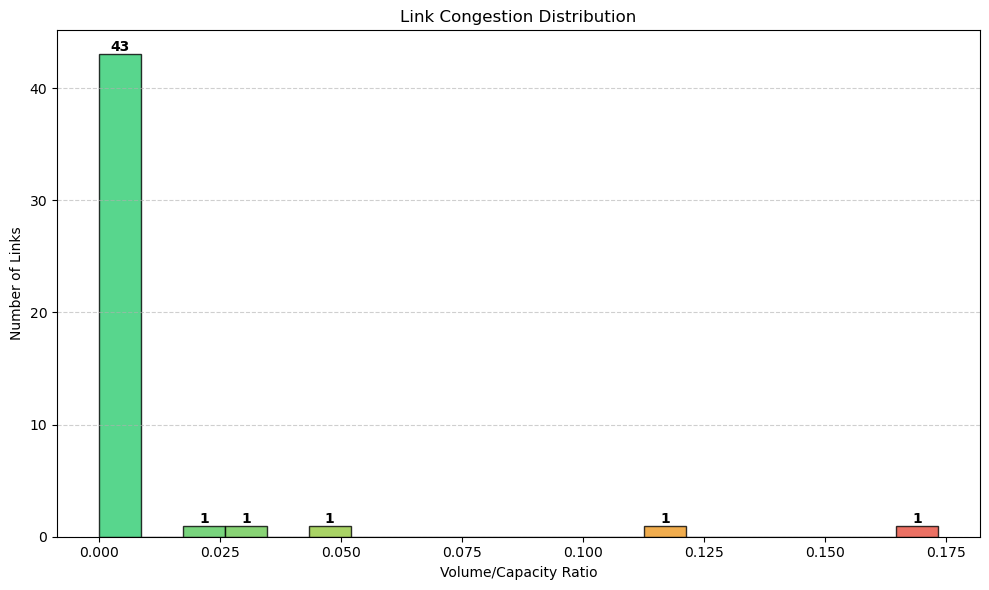

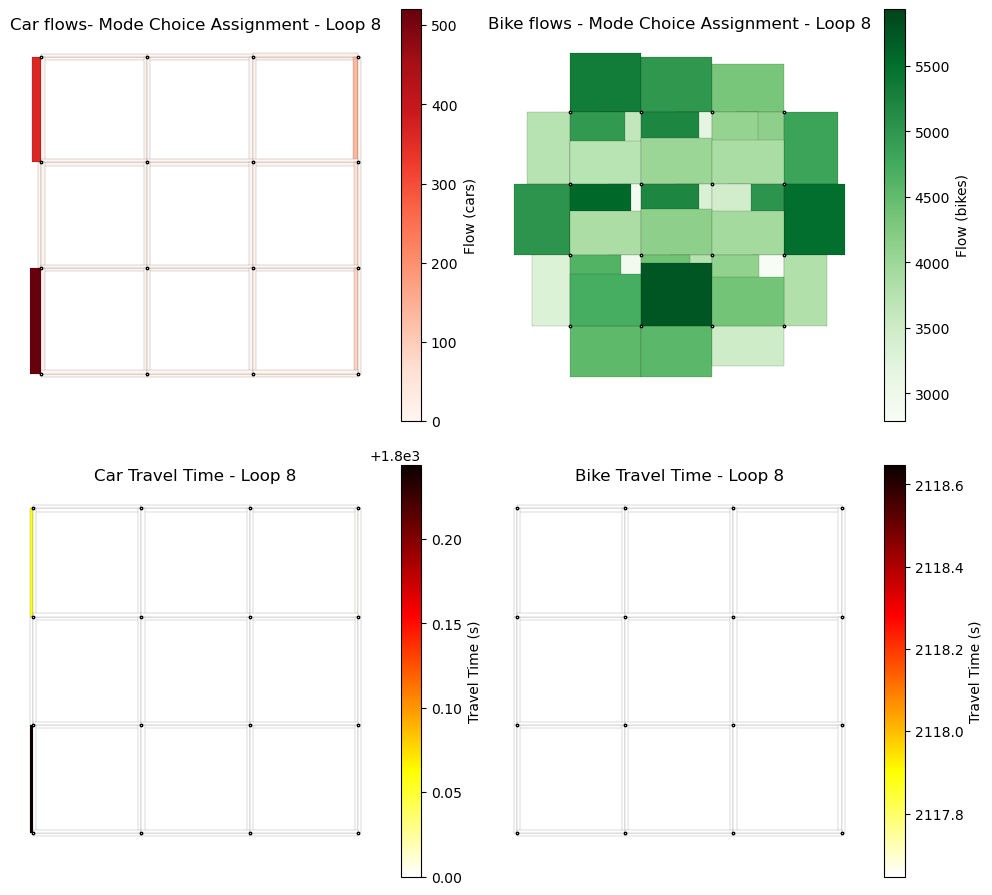


--- Mode Choice Loop 9 ---
Mode shares with skimming: Car = 99.930 %, Bike = 0.070%


DUE completed in 0.52s | RGAP: 0.000068 | TTT: 638225815
Stochastic (bikes) completed in 0.01s | TTT: 104650


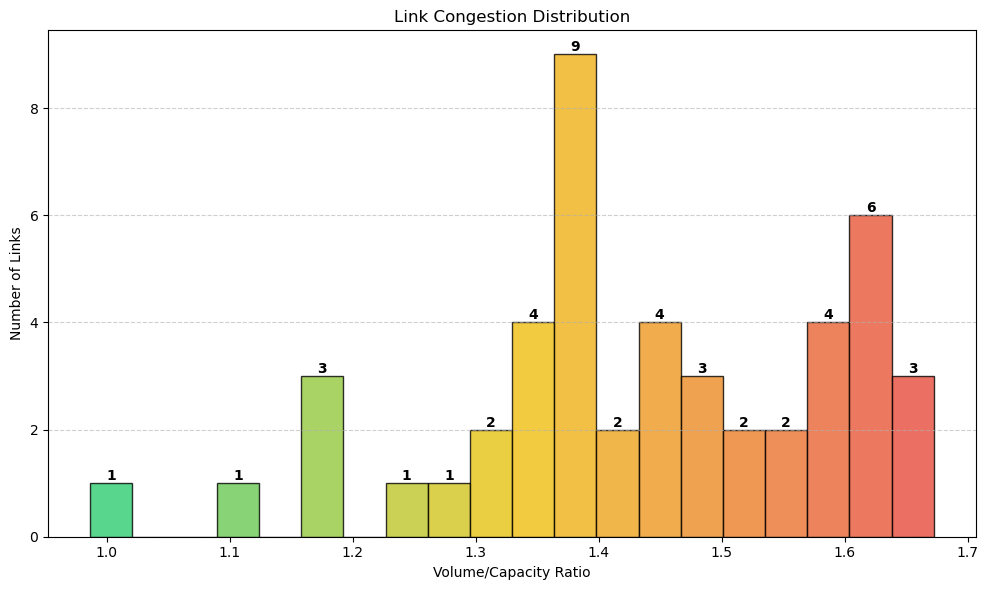

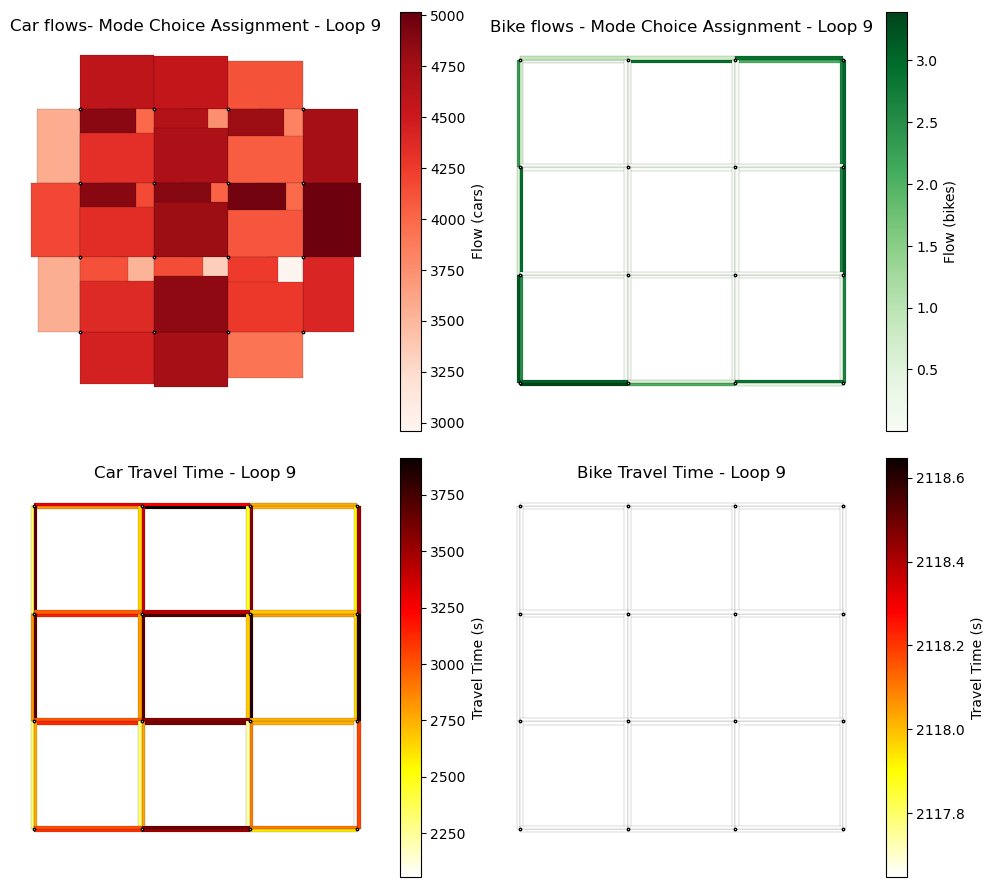


--- Mode Choice Loop 10 ---
Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


DUE completed in 0.26s | RGAP: 0.000000 | TTT: 2938718
Stochastic (bikes) completed in 0.00s | TTT: 435894493


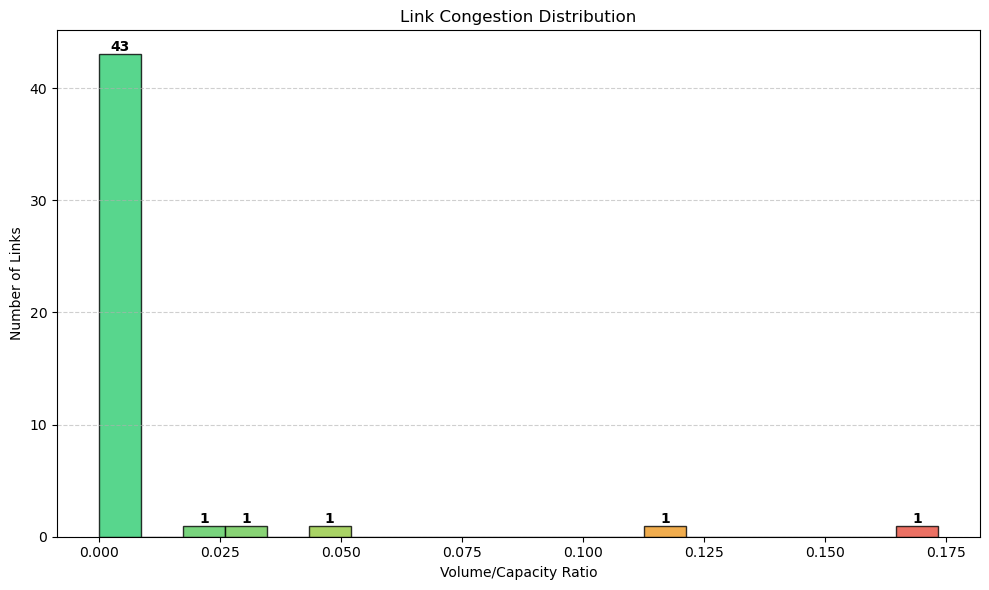

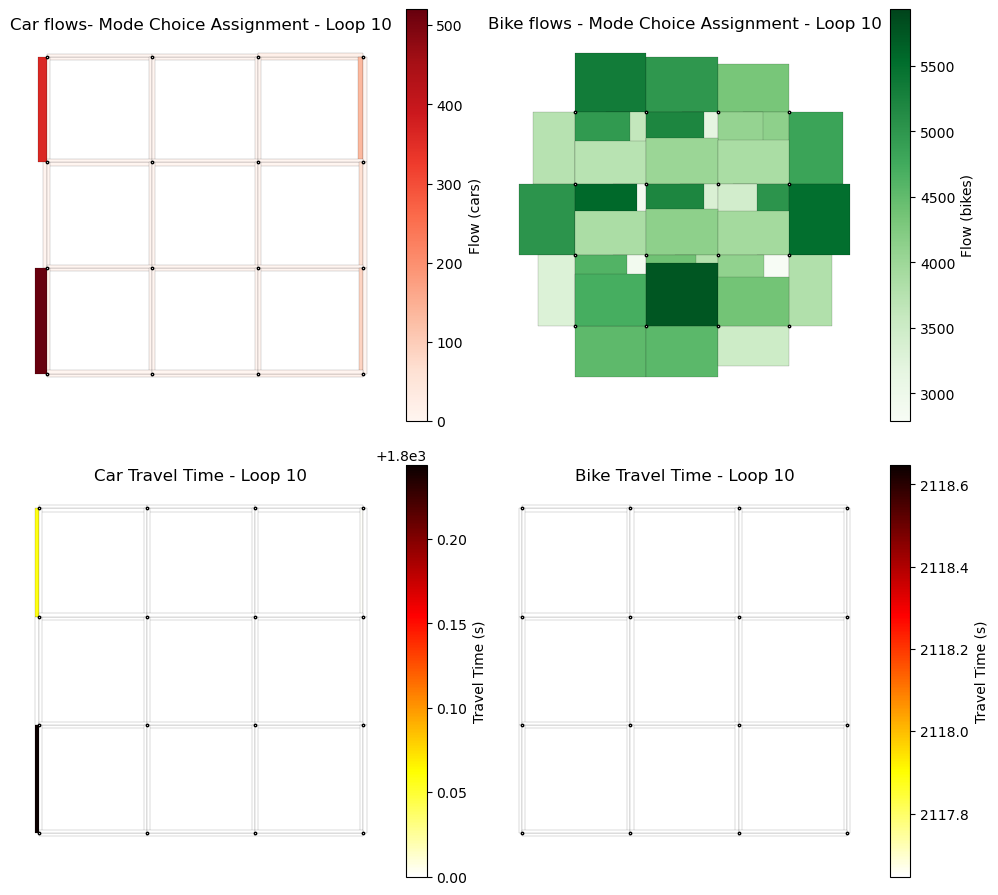

Mode shares with skimming: Car = 1.779 %, Bike = 98.221%


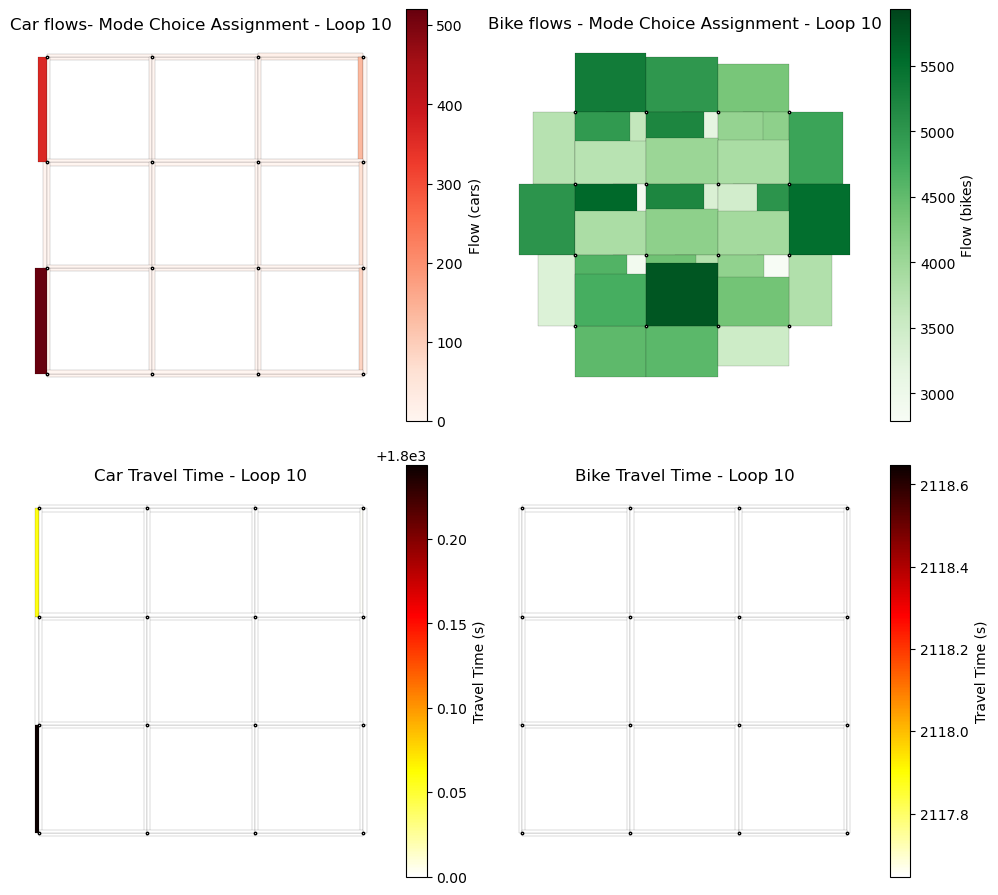

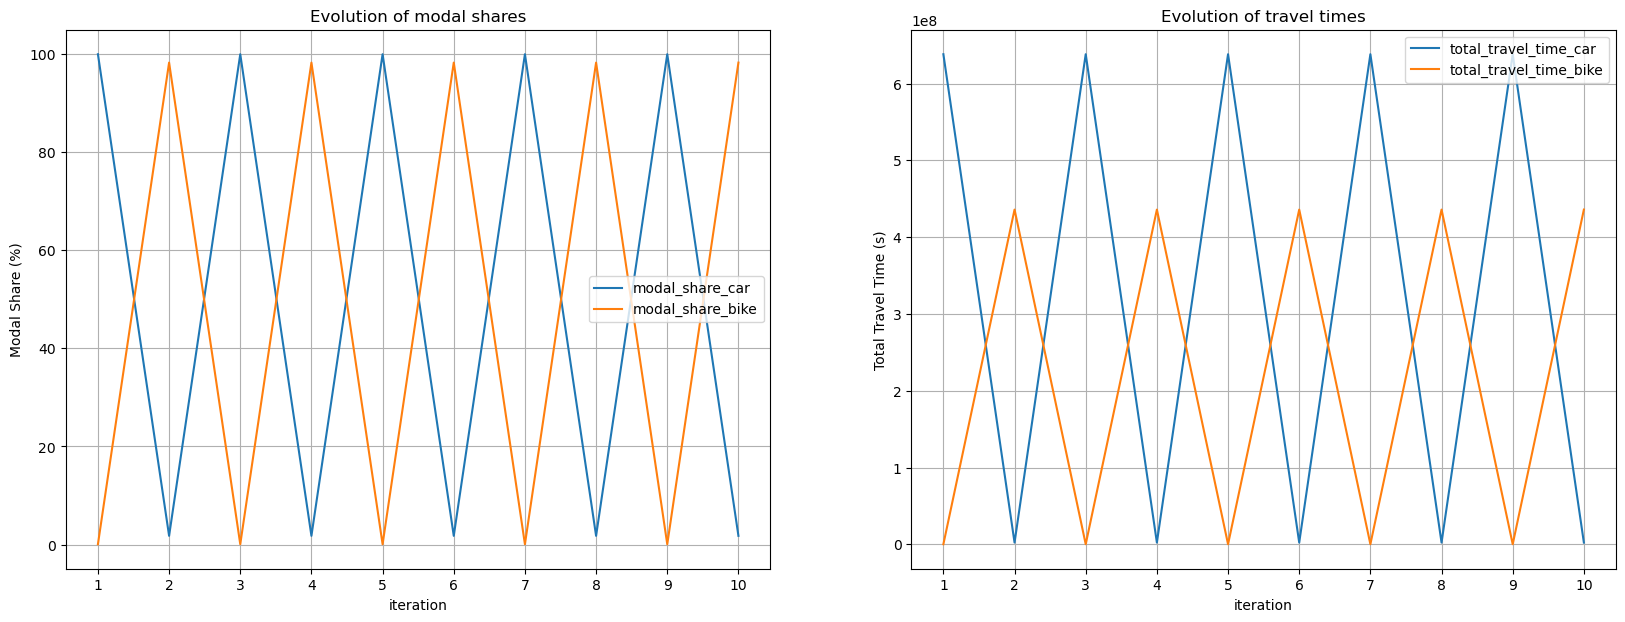

In [55]:
# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5

impact_coef = 1
mu_mode = 1.0
max_iter_mode_choice = 10
plot = True

edge_df["flow_car"] = 0
edge_df["flow_bike"] = 0

results_df = pd.DataFrame({'iteration': [0],
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan],
                        'total_travel_time_car': [np.nan],
                        'total_travel_time_bike': [np.nan],
                        'travel_time_per_car': [np.nan],
                        'travel_time_per_bike': [np.nan]})

j = 0

while j < max_iter_mode_choice:
    if plot:
        print(f"\n--- Mode Choice Loop {j+1} ---")
    j += 1

    #create skim matrices
    skim_car = np.zeros((size_od,size_od))
    skim_bike = np.zeros((size_od,size_od))

    
    G_car = nx.DiGraph()                    #creation of networkx graph for car skimming
    for _, edge in edge_df.iterrows():
        if edge['a_node'] != edge['b_node']:
            G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

    # Car skimming using current edge travel times
    for origin in range(1, size_od+1):
        for destination in range(1, size_od+1):
            if origin != destination:
                try:
                    skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                except:
                    skim_car[origin-1, destination-1] = 9999

    
    
    G_bike = nx.DiGraph()                   #creation of networkx graph for bike skimming 
    for _, edge in edge_df.iterrows():
        if edge['a_node'] != edge['b_node']:
            G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])

    # Bike skimming using current edge travel times    
    for origin in range(1, size_od+1):
        for destination in range(1, size_od+1):
            if origin != destination:
                try:
                    skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                except:
                    skim_bike[origin-1, destination-1] = 9999

    # Calculate utilities and mode share for each OD pair
    od_mode_shares_skim = np.zeros((size_od,size_od,2)) # 3rd dimension: 0 for car, 1 for bike
    total_car_skim = 0
    total_bike_skim = 0

    for origin in range(1, size_od+1):
        for destination in range(1, size_od+1):
            if origin != destination and od_matrix.loc[origin, destination] > 0:
                # Utilities
                V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                # Probabilities using logit model
                exp_car = np.exp(mu_mode * V_car)
                exp_bike = np.exp(mu_mode * V_bike)
                P_car = exp_car / (exp_car + exp_bike)
                P_bike = exp_bike / (exp_car + exp_bike)

                od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                # Accumulate total mode shares
                total_car_skim += od_matrix.loc[origin, destination] * P_car
                total_bike_skim += od_matrix.loc[origin, destination] * P_bike
    if plot:            
        print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
    # Update OD matrices based on mode shares
    updated_od_car = pd.DataFrame(0, index=range(1,size_od+1), columns=range(1,size_od+1))
    updated_od_bike = pd.DataFrame(0, index=range(1,size_od+1), columns=range(1,size_od+1))

    for origin in range(1, size_od+1):
        for destination in range(1, size_od+1):
            if origin != destination:
                total_od = od_matrix.loc[origin, destination]
                P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                updated_od_car.loc[origin, destination] = total_od * P_car
                updated_od_bike.loc[origin, destination] = total_od * P_bike
    
    updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
    updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

    #run traffic assignments with updated OD matrices
    car_results_mode_choice = ta_due(
                                edge_df,
                                updated_od_car,
                                algorithm='bfw',
                                time_field='travel_time_car',
                                cost_field='travel_time_car',
                                capacity_field='capacity_cars',
                                max_iter=500,
                                tolerance=1e-4,
                                verbose=True
                                )
    
    edge_df = car_results_mode_choice['network'].copy()
    edge_df["flow_car"] = edge_df["flow"]
    edge_df["ratio_flow_capacity_car"] = edge_df["ratio"]
    edge_df = pd.DataFrame.from_dict(edge_df)
    if plot :
        plot_vc_histogram(edge_df, capacity_col='capacity_cars', bins=20)

    bike_results_mode_choice = ta_stochastic(
                                edge_df, 
                                updated_od_bike, 
                                mode='bikes',
                                time_field='travel_time_bike', 
                                cost_field='travel_time_bike', ### LENGTH OR LENGTH_BI?
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                verbose=True
                                )
    
    edge_df = bike_results_mode_choice['network'].copy()
    edge_df["flow_bike"]= edge_df["flow"]
    edge_df = pd.DataFrame.from_dict(edge_df)

    #calculate congested time for cars
    calculate_congested_time(edge_df, flow_name='flow_car',free_flow_time_name='free_flow_time', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
    if plot:
        fig, axes = plt.subplots(2,2, figsize=(10,10))
        plot_network(edge_df, node_df, width_col='flow_car', color_col_num='flow_car', cmap='Reds', title=f'Car flows- Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (cars)', base_width=1, width_scale=50, ax=axes[0,0])
        plot_network(edge_df, node_df, width_col='flow_bike', color_col_num='flow_bike', cmap='Greens', title=f'Bike flows - Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (bikes)', base_width=1, width_scale=50, ax=axes[0,1])
        plot_network(edge_df, node_df, color_col_num='travel_time_car', cmap='hot_r', title=f'Car Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,0])
        plot_network(edge_df, node_df, color_col_num='travel_time_bike', cmap='hot_r', title=f'Bike Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,1])
        plt.show()
    
    results_df.loc[j-1, 'iteration'] = j
    results_df.loc[j-1, 'modal_share_car'] = 100*total_car_skim / od_matrix.values.sum()
    results_df.loc[j-1, 'modal_share_bike'] = 100*total_bike_skim / od_matrix.values.sum()
    total_travel_time_car = (edge_df['travel_time_car'] * edge_df['flow_car']).sum()
    total_travel_time_bike = (edge_df['travel_time_bike'] * edge_df['flow_bike']).sum()
    results_df.loc[j-1, 'total_travel_time_car'] = total_travel_time_car
    results_df.loc[j-1, 'total_travel_time_bike'] = total_travel_time_bike
    results_df.loc[j-1, 'travel_time_per_car'] = total_travel_time_car / updated_od_car.values.sum()
    results_df.loc[j-1, 'travel_time_per_bike'] = total_travel_time_bike / updated_od_bike.values.sum()

print(f"Mode shares with skimming: Car = {total_car_skim/(total_car_skim+total_bike_skim)*100 :.3f} %, Bike = {total_bike_skim/(total_car_skim+total_bike_skim)*100:.3f}%")
fig, axes = plt.subplots(2,2, figsize=(10,10))
plot_network(edge_df, node_df, width_col='flow_car', color_col_num='flow_car', cmap='Reds', title=f'Car flows- Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (cars)', base_width=1, width_scale=50, ax=axes[0,0])
plot_network(edge_df, node_df, width_col='flow_bike', color_col_num='flow_bike', cmap='Greens', title=f'Bike flows - Mode Choice Assignment - Loop {j}', node_size=3, colorbar_label='Flow (bikes)', base_width=1, width_scale=50, ax=axes[0,1])
plot_network(edge_df, node_df, color_col_num='travel_time_car', cmap='hot_r', title=f'Car Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,0])
plot_network(edge_df, node_df, color_col_num='travel_time_bike', cmap='hot_r', title=f'Bike Travel Time - Loop {j}', node_size=3, colorbar_label='Travel Time (s)', base_width=1, ax=axes[1,1])
plt.show()

fig, axes = plt.subplots(1,2, figsize=(20,7))
results_df.plot.line(x='iteration', y=['modal_share_car','modal_share_bike'], title='Evolution of modal shares', ax=axes[0])
results_df.plot.line(x='iteration', y=['total_travel_time_car','total_travel_time_bike'], title='Evolution of travel times', ax=axes[1])
axes[0].set_ylabel('Modal Share (%)')
axes[1].set_ylabel('Total Travel Time (s)')
axes[0].set_xticks(results_df['iteration'])
axes[1].set_xticks(results_df['iteration'])
axes[0].grid(True)
axes[1].grid(True)
plt.show()